In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV,cross_val_score, KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score,matthews_corrcoef,make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.under_sampling import ClusterCentroids
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier
import itertools


## Nested Cross Validation

In [129]:

data = pd.read_csv("full_data.csv")
data = data.drop(columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "LOS_HOSPITAL", "LOS_ICU", "HOSPITAL_EXPIRE_FLAG"])
data["GENDER"] = (data["GENDER"] == 'M') 
data.replace([np.inf, -np.inf], np.nan, inplace=True)  
data.fillna(value=0, inplace=True)  
data = data.astype('float32')  


train_data, test_data = train_test_split(data, test_size=0.2, random_state=505,stratify=data['EXPIRE_FLAG_30D'])
train_label = train_data["EXPIRE_FLAG_30D"]
train_data = train_data.drop(columns=["EXPIRE_FLAG_30D"])
test_label = test_data["EXPIRE_FLAG_30D"]
test_data = test_data.drop(columns=["EXPIRE_FLAG_30D"])



elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [130]:
train_data.shape

(24301, 113)

In [ ]:
mcc_scorer = make_scorer(matthews_corrcoef)

# ------------------------------
# 4. Define Shared Hyperparameter Grid
# ------------------------------
# Define the range of hyperparameters to tune
learning_rates = [0.1, 0.01]
max_depths = [8, 10]
n_estimators = [300, 500]
subsamples = [0.8, 1.0]
reg_alphas = [0, 0.1,0.2]
delta_step = [0,1]

# Create a list of dictionaries where each dictionary enforces the same hyperparameters across all models
param_combinations = list(
    itertools.product(learning_rates, max_depths, n_estimators, subsamples, reg_alphas)
)

param_grid = []
for lr, md, ne, ss, ra, ds in param_combinations:
    param_grid.append({
        'weight_model__xgb__learning_rate': [lr],
        'SMOTE_model__xgb__learning_rate': [lr],
        'xgb_model__xgb__learning_rate': [lr],
        
        'weight_model__xgb__max_depth': [md],
        'SMOTE_model__xgb__max_depth': [md],
        'xgb_model__xgb__max_depth': [md],
        
        'weight_model__xgb__n_estimators': [ne],
        'SMOTE_model__xgb__n_estimators': [ne],
        'xgb_model__xgb__n_estimators': [ne],
        
        'weight_model__xgb__subsample': [ss],
        'SMOTE_model__xgb__subsample': [ss],
        'xgb_model__xgb__subsample': [ss],
        
        'weight_model__xgb__reg_alpha': [ra],
        'SMOTE_model__xgb__reg_alpha': [ra],
        'xgb_model__xgb__reg_alpha': [ra],

        'weight_model__xgb__max_delta_step': [ds],
        'SMOTE_model__xgb__max_delta_step': [ds],
        'xgb_model__xgb__max_delta_step': [ds],

    })

# ------------------------------
# 5. Define Base Pipelines for Stacking
# ------------------------------

# Feature Selector using SelectFromModel with XGBoost
feature_selector = SelectFromModel(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=505,
        n_estimators=500,
        max_depth=15,
        reg_alpha=0.3,
        scale_pos_weight=9,
        tree_method='gpu_hist'
    ),
    threshold=0.005
)

# Pipeline 1: Weighted Model (Class Weighting)
pipeline_weight = Pipeline([
    ('feature_selection', feature_selector),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',  # Use built-in metric
        random_state=505,
        tree_method='gpu_hist'
    ))
])

# Pipeline 2: SMOTE Model (Oversampling)
pipeline_SMOTE = Pipeline([
    ('feature_selection', feature_selector),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=10, sampling_strategy=0.3, random_state=505)),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=505,
        tree_method='gpu_hist'
    ))
])

# Pipeline 3: Standard XGBoost Model with scale_pos_weight=1
pipeline_xgb = Pipeline([
    ('feature_selection', feature_selector),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=505,
        scale_pos_weight=1,  # No class weighting
        tree_method='gpu_hist'
    ))
])

# ------------------------------
# 6. Define Stacking Classifier
# ------------------------------
estimators = [
    ('weight_model', pipeline_weight),
    ('SMOTE_model', pipeline_SMOTE),
    ('xgb_model', pipeline_xgb)
]

meta_learner = LogisticRegression(random_state=505, solver='lbfgs', max_iter=1000)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    passthrough=False,
    stack_method='predict_proba',
    n_jobs=-1
)

# ------------------------------
# 7. Define Cross-Validation Strategy
# ------------------------------
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------------
# 8. Nested Cross-Validation Loop
# ------------------------------
outer_scores = []
best_params_all = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(train_data, train_label)):
    print(f"\nStarting Fold {fold + 1}")
    
    # Split data into training and validation for the current fold
    X_train, X_val = train_data.iloc[train_idx], train_data.iloc[test_idx]
    y_train, y_val = train_label.iloc[train_idx], train_label.iloc[test_idx]
    
    # Initialize GridSearchCV with the stacking classifier
    grid_search = GridSearchCV(
        estimator=stacking_clf,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=mcc_scorer,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    
    # Fit GridSearchCV on the training data of the current fold
    try:
        grid_search.fit(X_train, y_train)
    except Exception as e:
        print(f"GridSearch failed for Fold {fold + 1}: {e}")
        continue
    
    # Retrieve the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Make predictions on the validation set
    y_pred = best_model.predict(X_val)
    
    # Calculate MCC for the current fold
    mcc = matthews_corrcoef(y_val, y_pred)
    outer_scores.append(mcc)
    
    # Store the best parameters
    best_params_all.append(grid_search.best_params_)
    
    print(f"Fold {fold + 1} complete. MCC: {mcc}")

## Model

### XGBoost

In [ ]:

data = pd.read_csv("full_data.csv")
data = data.drop(columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "LOS_HOSPITAL", "LOS_ICU", "HOSPITAL_EXPIRE_FLAG"])
data["GENDER"] = (data["GENDER"] == 'M') 
data.replace([np.inf, -np.inf], np.nan, inplace=True)  
data.fillna(value=0, inplace=True)  
data = data.astype('float32')  


train_data, test_data = train_test_split(data, test_size=0.2,random_state=505,stratify=data["EXPIRE_FLAG_30D"].astype(int).values)
train_label = train_data["EXPIRE_FLAG_30D"]
train_data = train_data.drop(columns=["EXPIRE_FLAG_30D"])
test_label = test_data["EXPIRE_FLAG_30D"]
test_data = test_data.drop(columns=["EXPIRE_FLAG_30D"])


feature_selector=XGBClassifier(use_label_encoder=False, eval_metric=mcc_scorer, random_state=505, tree_method='gpu_hist',
                               n_estimators=500, max_depth=15, reg_alpha=0.3,scale_pos_weight=9)
feature_selector.fit(train_data,train_label)
mask = feature_selector.feature_importances_ > 0.005
train_data=train_data.loc[:, mask]
test_data=test_data.loc[:,mask]

scaler=StandardScaler()
train_data=scaler.fit_transform(train_data)
test_data=scaler.transform(test_data)

def mcc_metric(y_pred, dtrain):
    # For binary:logistic, y_pred are predicted probabilities
    # Convert them to class labels using a threshold of 0.5
    y_true = dtrain.get_label()
    y_pred_label = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred_label)
    return 'mcc', mcc, True  # True indicates higher is better


smote = SMOTE(k_neighbors=10,sampling_strategy=0.3,random_state=505)
train_data_resample, train_label_resample = smote.fit_resample(train_data, train_label)


SMOTE_model=XGBClassifier(use_label_encoder=False, eval_metric=mcc_metric, random_state=505,
                               n_estimators=500, max_depth=10,scale_pos_weight=1,max_delta_step=0)
SMOTE_model.fit(train_data_resample, train_label_resample)

weight_model=XGBClassifier(use_label_encoder=False, eval_metric=mcc_metric, random_state=505,
                               n_estimators=500, max_depth=10,scale_pos_weight=9,max_delta_step=0)
weight_model.fit(train_data, train_label)

base_model=XGBClassifier(use_label_encoder=False, eval_metric=mcc_metric, random_state=505,
                               n_estimators=500, max_depth=10,scale_pos_weight=1,max_delta_step=0)
base_model.fit(train_data, train_label)

weight_predictions = weight_model.predict_proba(test_data)
SMOTE_predictions = SMOTE_model.predict_proba(test_data)
undersample_predictions = base_model.predict_proba(test_data)


ensemble_features=np.stack([weight_model.predict_proba(train_data)[:,0],
                            SMOTE_model.predict_proba(train_data)[:,0],
                            base_model.predict_proba(train_data)[:,0]])
ensembler=SVC(probability=True).fit(ensemble_features.T,train_label)
# average_prediction=(xgb1.predict_proba(test_data)+xgb2.predict_proba(test_data)+xgb3.predict_proba(test_data))/3
# xgb_predictions=average_prediction[:,0]>0.5

test_ensemble_features=np.stack([weight_model.predict_proba(test_data)[:,0],
                                 SMOTE_model.predict_proba(test_data)[:,0],
                                 base_model.predict_proba(test_data)[:,0]])
xgb_predictions=ensembler.predict(test_ensemble_features.T)
print(classification_report(test_label, xgb_predictions))
print("Matthew Correlation Coefficient:",matthews_corrcoef(test_label,xgb_predictions))

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[14:15:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [75]:
print("Matthew Correlation Coefficient:",matthews_corrcoef(test_label,xgb_predictions))

Matthew Correlation Coefficient: 0.6811922631234094


In [131]:
feature_selector.feature_importances_

array([0.        , 0.01586649, 0.        , 0.00803316, 0.01054761,
       0.00679425, 0.00832451, 0.0069182 , 0.0078785 , 0.00926475,
       0.00874335, 0.00538832, 0.        , 0.00583272, 0.01538387,
       0.00667423, 0.00611869, 0.00545788, 0.00490297, 0.01527666,
       0.00915292, 0.00663886, 0.0091542 , 0.00549588, 0.04431553,
       0.00682484, 0.00484084, 0.00653144, 0.00884398, 0.        ,
       0.00705871, 0.0117367 , 0.04765754, 0.        , 0.        ,
       0.        , 0.02700976, 0.03296686, 0.01403123, 0.0065145 ,
       0.07909343, 0.00369697, 0.00510795, 0.00581261, 0.024419  ,
       0.00481435, 0.00474657, 0.00967672, 0.00501062, 0.00563538,
       0.0047987 , 0.00395037, 0.0162614 , 0.        , 0.01900688,
       0.00685354, 0.01817852, 0.00723562, 0.00365848, 0.00451163,
       0.00724291, 0.00424917, 0.0106604 , 0.00482667, 0.00466162,
       0.00524569, 0.00379901, 0.00515927, 0.008162  , 0.00788524,
       0.00774085, 0.        , 0.00761575, 0.01076577, 0.01172

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      5434
         1.0       0.76      0.67      0.71       642

    accuracy                           0.94      6076
   macro avg       0.86      0.82      0.84      6076
weighted avg       0.94      0.94      0.94      6076



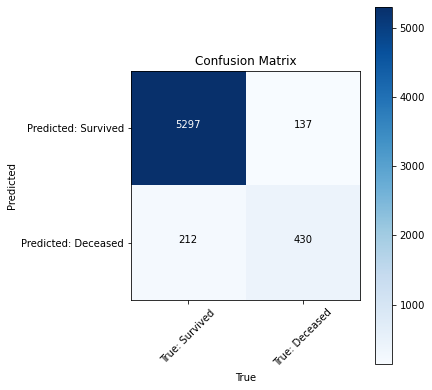

In [29]:
# 输出分类报告和混淆矩阵
print(classification_report(test_label, xgb_predictions))
cm = confusion_matrix(test_label, xgb_predictions)

# 绘制混淆矩阵
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# 设置轴标签，x轴为 True，y轴为 Predicted
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['True: Survived', 'True: Deceased'], rotation=45)
plt.yticks(tick_marks, ['Predicted: Survived', 'Predicted: Deceased'])

plt.xlabel('True')
plt.ylabel('Predicted')

# 在混淆矩阵中显示数字
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# Interpretation with a Tree model

Our Surrogate model accuracy is: 0.945194206714944


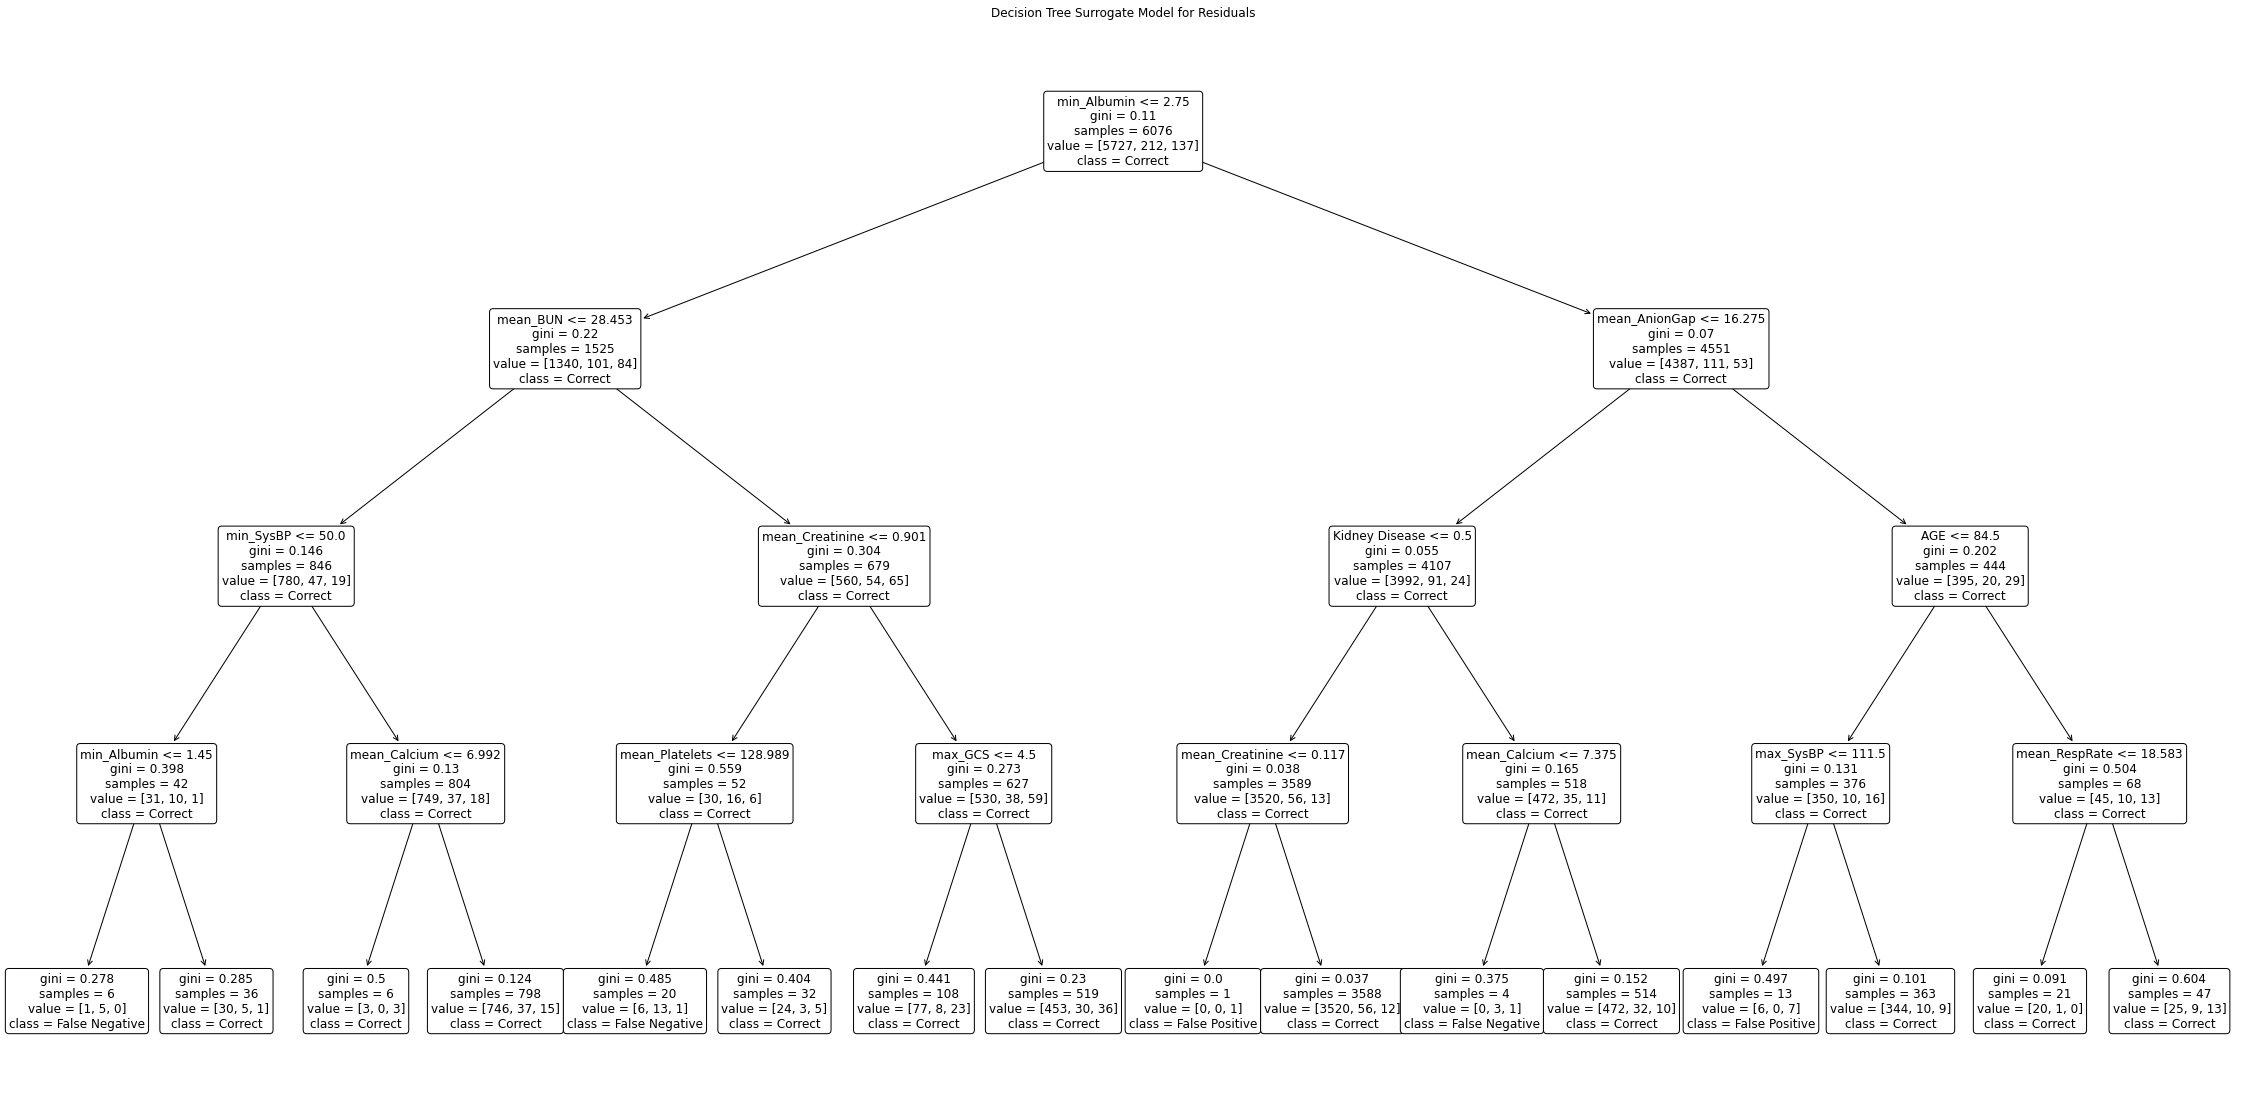

In [132]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# xgb_predictions=xgb_predictions.astype(int)
# test_label=test_label.to_numpy().astype(int)

residual = np.where(
    xgb_predictions == test_label,
    'Correct',
    np.where(
        (xgb_predictions == 1) & (test_label == 0),
        'False Positive',
        'False Negative'
    )
)

residual = pd.Series(residual, name='residual')


label_encoder = LabelEncoder()
residual=label_encoder.fit_transform(residual)

# Initialize the Decision Tree Classifier
residual_tree = DecisionTreeClassifier(
    max_depth=4,  # Limit depth for interpretability
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=505
)

# Fit the model
residual_tree.fit(test_data, residual)
print("Our Surrogate model accuracy is:",residual_tree.score(test_data, residual))

if not all(isinstance(name, str) for name in test_data.columns):
    feature_names = [str(name) for name in test_data.columns]
else:
    feature_names = test_data.columns.tolist()

# b. Ensure Class Names Are Strings
class_names = [str(name) for name in label_encoder.classes_]


plt.figure(figsize=(40,20))
tree.plot_tree(
    residual_tree, 
    feature_names=feature_names,
    class_names=class_names,
    filled=False,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree Surrogate Model for Residuals")
plt.savefig("CART_interpreter.pdf")
plt.show()


# SHAP value

In [ ]:
import shap

estimators = [
    ('weight_model', weight_model),
    ('SMOTE_model', SMOTE_model),
    ('undersample_model', base_model)
]


stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=SVC(probability=True, random_state=42),
    cv=2,
    passthrough=False,  # Whether to include the original features in the final estimator
)

stacking_clf.fit(train_data, train_label)

X_fn_subset = test_data[residual==1]

# Define a background dataset for KernelExplainer (use a sample from training data)
background = train_data[np.random.choice(np.arange(train_data.shape[0]),size=100)]

# Define a prediction function for the Stacking Classifier
def model_predict(data):
    return stacking_clf.predict_proba(data)[:, 1]


# Initialize KernelExplainer with the background dataset
print("Initializing SHAP KernelExplainer...")
explainer = shap.KernelExplainer(model_predict, background, link="logit")
print("KernelExplainer initialized.\n")

# Compute SHAP values for the False Negatives subset
print("Computing SHAP values for False Negatives...")
shap_values = explainer.shap_values(X_fn_subset, nsamples=100)


[23:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

  0%|          | 0/212 [00:00<?, ?it/s]

Initializing SHAP KernelExplainer...
KernelExplainer initialized.

Computing SHAP values for False Negatives...


 22%|██▏       | 46/212 [02:05<07:16,  2.63s/it]Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=1.484e-03, previous alpha=1.483e-03, with an active set of 30 regressors.
Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.
To use regular inverse do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
 29%|██▉       | 61/212 [02:45<06:55,  2.75s/it]Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.092e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of 

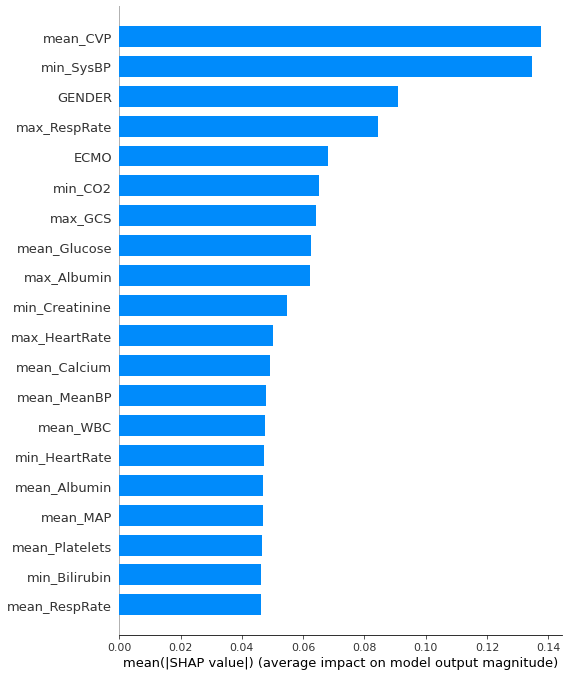

In [114]:
shap.summary_plot(shap_values, X_fn_subset, plot_type="bar",feature_names=X_train.columns,show=False)
plt.savefig('SHAP_for_falsenegative.pdf')

In [ ]:
import shap

estimators = [
    ('weight_model', weight_model),
    ('SMOTE_model', SMOTE_model),
    ('undersample_model', base_model)
]


stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=SVC(probability=True, random_state=42),
    cv=2,
    passthrough=False,  # Whether to include the original features in the final estimator
)

stacking_clf.fit(train_data, train_label)

X_fp_subset = test_data[residual==2]

# Define a background dataset for KernelExplainer (use a sample from training data)
background = train_data[np.random.choice(np.arange(train_data.shape[0]),size=100)]

# Define a prediction function for the Stacking Classifier
def model_predict(data):
    return stacking_clf.predict_proba(data)[:, 1]


# Initialize KernelExplainer with the background dataset
print("Initializing SHAP KernelExplainer...")
explainer = shap.KernelExplainer(model_predict, background, link="logit")
print("KernelExplainer initialized.\n")

# Compute SHAP values for the False Negatives subset
print("Computing SHAP values for False Negatives...")
shap_values = explainer.shap_values(X_fp_subset, nsamples=100)


[00:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

  0%|          | 0/137 [00:00<?, ?it/s]

Initializing SHAP KernelExplainer...
KernelExplainer initialized.

Computing SHAP values for False Negatives...


100%|██████████| 137/137 [06:02<00:00,  2.65s/it]


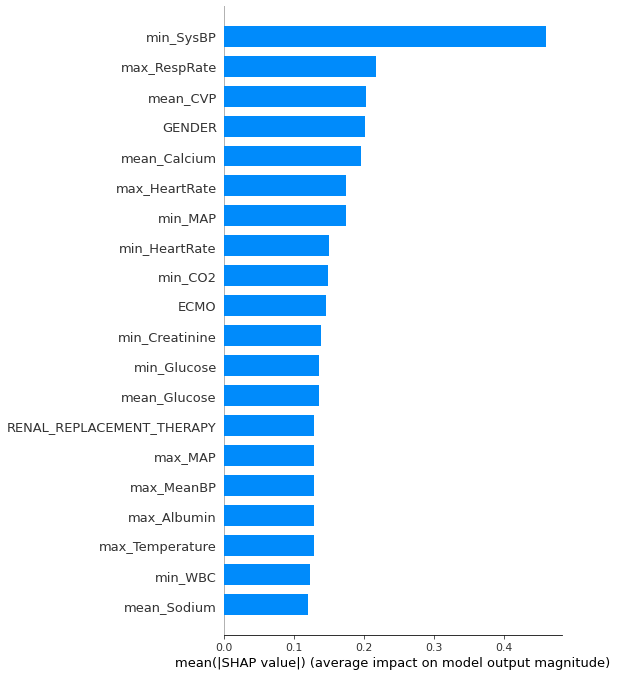

In [117]:
shap.summary_plot(shap_values, X_fp_subset, plot_type="bar",feature_names=X_train.columns,show=False)
plt.savefig('SHAP_for_falsepositive.pdf')